In [1]:
import os
import glob
import shutil
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

## Train Test Validation Split

In [2]:
def train_test_split():
    #specifying directory
    root_dir = "C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2\\kvasir-dataset-v2\\"
    #checking if train data exists already
    if os.path.isdir(root_dir+"train\\"):
        print("Train test split completed!")
    else:
        print("########### Train Test Val Script started ###########")

        
        classes = ['dyed-lifted-polyps',
            'dyed-resection-margins',
            'esophagitis','normal-cecum',
            'normal-pylorus','normal-z-line',
            'polyps',
            'ulcerative-colitis']


        val_ratio = 0.15
        test_ratio = 0.15
        
        # checking for files in each class folder
        for cls in classes:
            
          # Creating partitions of the data after shuffeling
            print("$$$$$$$ Class Name " + cls + " $$$$$$$")
            src = root_dir +"\\" + cls  # Folder to copy images from

            allFileNames = os.listdir(src)
            #setting seed with last 3 digits of ID number
            random.Random(427).shuffle(allFileNames)
            # splitting of file names in train, validation, test ratio
            train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                    [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                    int(len(allFileNames) * (1 - val_ratio)),
                                                                    ])
            # making list of train, test and validation file names
            train_FileNames = [src + '\\' + name for name in train_FileNames.tolist()]
            val_FileNames = [src + '\\' + name for name in val_FileNames.tolist()]
            test_FileNames = [src + '\\' + name for name in test_FileNames.tolist()]

            print('Total images: '+ str(len(allFileNames)))
            print('Training: '+ str(len(train_FileNames)))
            print('Validation: '+  str(len(val_FileNames)))
            print('Testing: '+ str(len(test_FileNames)))

            # # Creating Train / Val / Test folders (One time use)
            os.makedirs(root_dir + '//train//' + cls)
            os.makedirs(root_dir + '//val//' + cls)
            os.makedirs(root_dir + '//test//' + cls)

            # Copy-pasting images from the class folder to train/val/test folders by checking in list of corresponding file names
            for name in train_FileNames:
                shutil.copy(name, root_dir + '//train//' + cls)

            for name in val_FileNames:
                shutil.copy(name, root_dir + '//val//' + cls)

            for name in test_FileNames:
                shutil.copy(name, root_dir + '//test//' + cls)

        print("########### Train Test Val Script Ended ###########")

train_test_split()

Train test split completed!


## Image Data Augmentation

In [20]:
# setting image height, width and number of channels
img_wid = 200
img_height = 200
img_channel = 3 
# Image augmentation using image data generator
train_dataAugmentation = ImageDataGenerator(
  #  rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.5,0.9),
    # shear_range=45,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    fill_mode='nearest',
    )
# only rescaling  of images is performed for validation and testing data sets
val_dataAugmentation = ImageDataGenerator(rescale=1./255)
test_dataAugmentation = ImageDataGenerator(rescale=1./255)

#Images picked up from directory for augmentation. At a time 32 images are picked up
train_data_generator=train_dataAugmentation.flow_from_directory('C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2\\kvasir-dataset-v2\\train',
                                                 target_size=(img_wid,img_height),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_data_generator = val_dataAugmentation.flow_from_directory('C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2\\kvasir-dataset-v2\\val',
                                        target_size=(img_wid,img_height),
                                       batch_size=8,
                                       class_mode='categorical')

test_data_generator = test_dataAugmentation.flow_from_directory('C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2\\kvasir-dataset-v2\\test',
                                        target_size=(img_wid,img_height),
                                       batch_size=8,
                                       class_mode='categorical')
# to know how many samples to be drawn from generator before declaring than an epoch is over. length(training data)// Batch size
step_size_train=train_data_generator.n//train_data_generator.batch_size 
# to know the number of data points to be used for validation at a time. length(validation data)// Batch size
step_size_valid=val_data_generator.n//val_data_generator.batch_size 

for v_img , v_label in train_data_generator : # check for image and label shape in traning data in a batch
    
    print('image shape ',v_img.shape)
    print('label  shape ',v_label.shape)
    break 

Found 5600 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
image shape  (32, 200, 200, 3)
label  shape  (32, 8)


## Printing of Sample Images

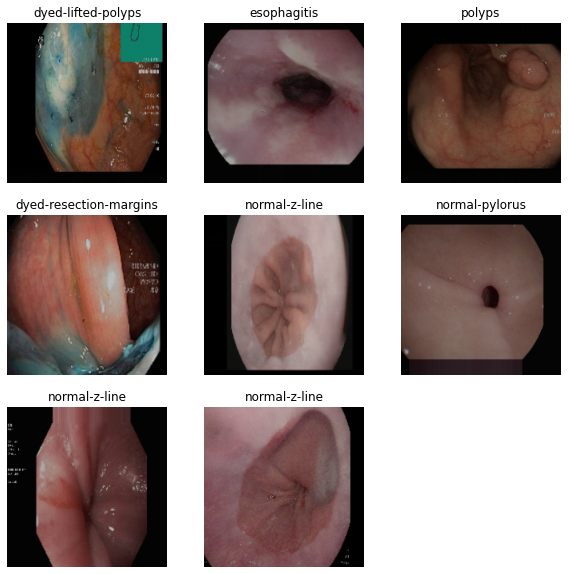

In [4]:
class_indices ={0:"dyed-lifted-polyps",1:"dyed-resection-margins",2:"esophagitis",3:"normal-cecum",4:"normal-pylorus",5:"normal-z-line",6:"polyps",7:"ulcerative-colitis"}

plt.figure(figsize=(10, 10))
# taking image and label from image datagenerator
for X_batch, y_batch in train_data_generator:
    for i in range(8):
        image=X_batch[i]
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(image)
        plt.title(class_indices[list(y_batch[i]).index(1.0)])
        plt.axis("off")
    break

## Model Validate Function

In [5]:
def model_train_validate(model,train,valid,steps_train,steps_valid,epoch):
    #compiling the model. loss, optimizer and metrics to be considered is specified
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #fitting the model.
    history = model.fit(train, # data from train generator
                        steps_per_epoch=steps_train,  # length(training data)// Batch size
                        validation_data=valid, # data from validation generator
                        validation_steps=steps_valid, # length(validation data)// Batch size
                        epochs=epoch,
                        callbacks = [EarlyStopping(monitor='val_loss', patience=10), # monitor validation losss in each epoch and  if it continuosly increases for more than 10 epochs, stop the run
                                     ModelCheckpoint(filepath='C:\\Users\\R00195427\\Desktop\\Assignment\\saved_model\\base_best_model.h5', monitor='val_loss', save_best_only=True)]) # save the best model
    _, acc = model.evaluate(valid, steps=len(valid), verbose=0) # evaluate the best fit model with validation data
    print('> %.3f' % (acc * 100.0)) 
    
    #calling function to display graphs for loss and accuracy
    summarize_diagnostics(history)

## Model Diagnostics Graph Function

In [12]:
def summarize_diagnostics(hist):
    # history will have 4 lists of values after model fit. train accuracy, val accuracy, train loss, val loss
    acc = hist.history['accuracy'] # Train accuracy from each epoch 
    val_acc = hist.history['val_accuracy'] # validation accuracy from each epoch 

    loss = hist.history['loss'] # Train loss from each epoch 
    val_loss = hist.history['val_loss'] # validation loss from each epoch 

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Base Model Definition

In [7]:
def base_model(img_wid,img_height,img_channel):
    
    model_base = models.Sequential()
    #layer1
    model_base.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(img_wid,img_height,img_channel)))
    model_base.add(layers.MaxPooling2D((2, 2)))
    #layer2
    model_base.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(img_wid,img_height,img_channel)))
    model_base.add(layers.MaxPooling2D((2, 2)))
    #flattening for dense neural network
    model_base.add(layers.Flatten())
    model_base.add(layers.Dense(128, activation='relu'))
    model_base.add(layers.Dense(8, activation='softmax'))

    return model_base

In [8]:
model_base = base_model(img_wid,img_height,img_channel) # creating base model
model_base.summary() # creating summary of model. summary of the model gives output shape and number of parameters after each layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 160000)            0         
                                                                 
 dense (Dense)               (None, 128)               2

## Base Model Train & Validate

Epoch 1/60
175/175 [==============================] - 154s 849ms/step - loss: 1.1727 - accuracy: 0.5245 - val_loss: 0.8837 - val_accuracy: 0.6000
Epoch 2/60
175/175 [==============================] - 158s 904ms/step - loss: 0.8262 - accuracy: 0.6300 - val_loss: 0.9363 - val_accuracy: 0.6025
Epoch 3/60
175/175 [==============================] - 149s 853ms/step - loss: 0.7421 - accuracy: 0.6650 - val_loss: 1.0896 - val_accuracy: 0.5758
Epoch 4/60
175/175 [==============================] - 167s 958ms/step - loss: 0.7335 - accuracy: 0.6620 - val_loss: 0.8753 - val_accuracy: 0.6358
Epoch 5/60
175/175 [==============================] - 162s 925ms/step - loss: 0.7022 - accuracy: 0.6827 - val_loss: 0.7837 - val_accuracy: 0.6792
Epoch 6/60
175/175 [==============================] - 156s 891ms/step - loss: 0.6798 - accuracy: 0.6870 - val_loss: 0.6866 - val_accuracy: 0.7025
Epoch 7/60
175/175 [==============================] - 152s 866ms/step - loss: 0.6766 - accuracy: 0.6896 - val_loss: 0.7550 -

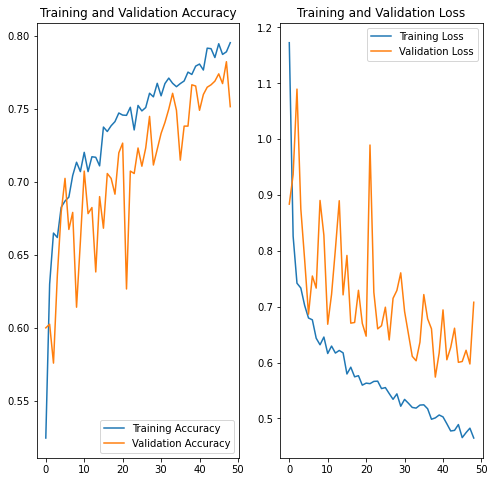

In [9]:
epoch=60
model_train_validate(model_base,train_data_generator,val_data_generator,step_size_train,step_size_valid,epoch) # model train and validation

## Base Model Test

In [25]:
base_best_model = load_model(filepath='C:\\Users\\R00195427\\Desktop\\Assignment\\saved_model\\base_best_model.h5')
loss_base,acc_base=base_best_model.evaluate(test_data_generator,steps=test_data_generator.n//test_data_generator.batch_size)
print ('The best model Loss : ',loss_base)
print ('The best model Accuracy : ',acc_base)

150/150 [==============================] - 19s 129ms/step - loss: 0.5320 - accuracy: 0.7742
The best model Loss :  0.5319865942001343
The best model Accuracy :  0.7741666436195374


## Advanced Model Definition

In [8]:
def adv_model(img_wid,img_height,img_channel):
    #layer1
    model_adv = models.Sequential()
    model_adv.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(200,200,3)))
    model_adv.add(BatchNormalization())
    model_adv.add(MaxPooling2D(pool_size=(2,2)))
    #layer2
    model_adv.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model_adv.add(BatchNormalization())
    model_adv.add(MaxPooling2D(pool_size=(2,2)))
    #layer3
    model_adv.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model_adv.add(BatchNormalization())
    model_adv.add(MaxPooling2D(pool_size=(2,2)))
    #layer4
    model_adv.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model_adv.add(BatchNormalization())
    model_adv.add(MaxPooling2D(pool_size=(2,2)))
    #layer5
    model_adv.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model_adv.add(BatchNormalization())
    model_adv.add(MaxPooling2D(pool_size=(2,2)))
    #layer6
    model_adv.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model_adv.add(BatchNormalization())
    model_adv.add(MaxPooling2D(pool_size=(2,2)))
    #layer7
    model_adv.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    model_adv.add(BatchNormalization())
    model_adv.add(MaxPooling2D(pool_size=(2,2)))
    #flattening for dense neural network
    model_adv.add(Flatten())
    model_adv.add(Dropout(0.2))
    #layer1
    model_adv.add(Dense(1024,activation='relu'))
    model_adv.add(Dropout(0.2))
    #layer2
    model_adv.add(Dense(512,activation='relu'))
    model_adv.add(Dropout(0.2))
    #layer3
    model_adv.add(Dense(256,activation='relu'))
    model_adv.add(Dense(8,activation='softmax'))

    return model_adv
# model compile and fit function
def model_train_validate_adv(model,train,valid,steps_train,steps_valid,epoch):
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    history = model.fit(train,
                        steps_per_epoch=steps_train,
                        validation_data=valid,
                        validation_steps=steps_valid,
                        epochs=epoch,
                        callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                                     ModelCheckpoint(filepath='C:\\Users\\R00195427\\Desktop\\Assignment\\saved_model\\adv_best_model.h5', monitor='val_loss', save_best_only=True)])
    _, acc = model.evaluate(valid, steps=len(valid), verbose=0)
    print('> %.3f' % (acc * 100.0)) 
    
    #calling function to display graphs for loss and accuracy
    summarize_diagnostics(history)

In [21]:
model_advanced = adv_model(img_wid,img_height,img_channel) 
model_advanced.summary() # creating summary of model. summary of the model gives output shape and number of parameters after each layer

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 batch_normalization_7 (Batc  (None, 200, 200, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization_8 (Batc  (None, 100, 100, 64)     256       
 hNormalization)                                                 
                                                      

## Advanced Model Train & Validation

Epoch 1/100
175/175 [==============================] - 152s 864ms/step - loss: 1.0495 - accuracy: 0.5273 - val_loss: 7.4102 - val_accuracy: 0.1250
Epoch 2/100
175/175 [==============================] - 150s 857ms/step - loss: 0.8418 - accuracy: 0.6091 - val_loss: 4.2565 - val_accuracy: 0.1825
Epoch 3/100
175/175 [==============================] - 149s 850ms/step - loss: 0.7692 - accuracy: 0.6468 - val_loss: 1.1156 - val_accuracy: 0.4967
Epoch 4/100
175/175 [==============================] - 149s 851ms/step - loss: 0.7565 - accuracy: 0.6577 - val_loss: 1.0990 - val_accuracy: 0.5392
Epoch 5/100
175/175 [==============================] - 150s 854ms/step - loss: 0.7330 - accuracy: 0.6612 - val_loss: 0.9183 - val_accuracy: 0.5875
Epoch 6/100
175/175 [==============================] - 149s 854ms/step - loss: 0.6843 - accuracy: 0.6841 - val_loss: 0.7095 - val_accuracy: 0.6800
Epoch 7/100
175/175 [==============================] - 149s 853ms/step - loss: 0.6729 - accuracy: 0.6932 - val_loss: 1

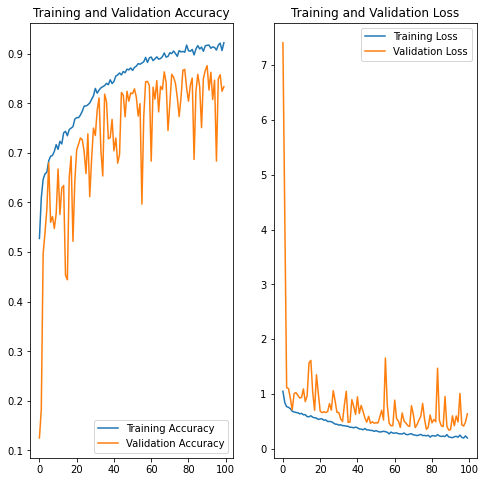

In [22]:
epoch=100
model_train_validate_adv(model_advanced,train_data_generator,val_data_generator,step_size_train,step_size_valid,epoch) # model train and validation

## Advanced Model Test

In [28]:
adv_best_model = load_model(filepath='C:\\Users\\R00195427\\Desktop\\Assignment\\saved_model\\adv_best_model.h5')
loss_adv,acc_adv=adv_best_model.evaluate(test_data_generator,steps=test_data_generator.n//test_data_generator.batch_size)
print ('The best model Loss : ',loss_adv)
print ('The best model Accuracy : ',acc_adv)

150/150 [==============================] - 19s 123ms/step - loss: 0.3105 - accuracy: 0.8825
The best model Loss :  0.31050848960876465
The best model Accuracy :  0.8824999928474426


### Summary Of Models

In [30]:
dict_base ={"Model Name": "Base Model","Test Data Loss":loss_base,"Test Data Accuracy":acc_base}
dict_adv ={"Model Name": "Advanced Model","Test Data Loss":loss_adv,"Test Data Accuracy":acc_adv}
model_frame= pd.DataFrame([dict_base, dict_adv])
model_frame

,Model Name,Test Data Loss,Test Data Accuracy
0,Base Model,0.531987,0.774167
1,Advanced Model,0.310508,0.882500


## Implementation of Mixup Augmentation

In [9]:
import numpy as np


class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2):
        """Constructor for mixup image data generator.

        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.

        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True
                                                        )

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True
                                                        )

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.

        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.

        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [10]:
img_height = 200
img_width = 200
img_channel=3


# image augmentation with ImageDataGenerator.
input_imgen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0,
    shear_range=0.05,
    zoom_range=0,
    brightness_range=(1, 1.3),
    horizontal_flip=True,
    fill_mode='nearest')

# Create training generator with mixup class.
train_generator_mixup = MixupImageDataGenerator(generator=input_imgen,
                                          directory='C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2\\kvasir-dataset-v2\\train',
                                          batch_size=32,
                                          img_height=img_height,
                                          img_width=img_width
                                          )

val_dataAugmentation = ImageDataGenerator(rescale=1./255)
test_dataAugmentation = ImageDataGenerator(rescale=1./255)


val_data_generator = val_dataAugmentation.flow_from_directory('C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2\\kvasir-dataset-v2\\val',
                                        target_size=(img_width,img_height),
                                       batch_size=8,
                                       class_mode='categorical')
test_data_generator = test_dataAugmentation.flow_from_directory('C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2\\kvasir-dataset-v2\\test',
                                        target_size=(img_width,img_height),
                                       batch_size=8,
                                       class_mode='categorical')



step_size_train=train_generator_mixup.n//train_generator_mixup.batch_size # to know how many samples to be drawn from generator before declaring than an epoch is over. length(training data)// Batch size
step_size_valid=val_data_generator.n//val_data_generator.batch_size # to know the number of data points to be used for validation at a time. length(validation data)// Batch size



Found 5600 images belonging to 8 classes.
Found 5600 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


## Mixup with Advanced Model

Epoch 1/80
175/175 [==============================] - 293s 2s/step - loss: 1.2321 - accuracy: 0.5450 - val_loss: 2.2338 - val_accuracy: 0.1717
Epoch 2/80
175/175 [==============================] - 286s 2s/step - loss: 1.0312 - accuracy: 0.6316 - val_loss: 1.8545 - val_accuracy: 0.2875
Epoch 3/80
175/175 [==============================] - 286s 2s/step - loss: 0.9834 - accuracy: 0.6500 - val_loss: 0.8184 - val_accuracy: 0.6567
Epoch 4/80
175/175 [==============================] - 287s 2s/step - loss: 0.9589 - accuracy: 0.6684 - val_loss: 0.8509 - val_accuracy: 0.5925
Epoch 5/80
175/175 [==============================] - 287s 2s/step - loss: 0.9224 - accuracy: 0.6812 - val_loss: 1.0567 - val_accuracy: 0.5550
Epoch 6/80
175/175 [==============================] - 287s 2s/step - loss: 0.8880 - accuracy: 0.7068 - val_loss: 0.7225 - val_accuracy: 0.7092
Epoch 7/80
175/175 [==============================] - 289s 2s/step - loss: 0.8684 - accuracy: 0.7150 - val_loss: 0.8114 - val_accuracy: 0.6700

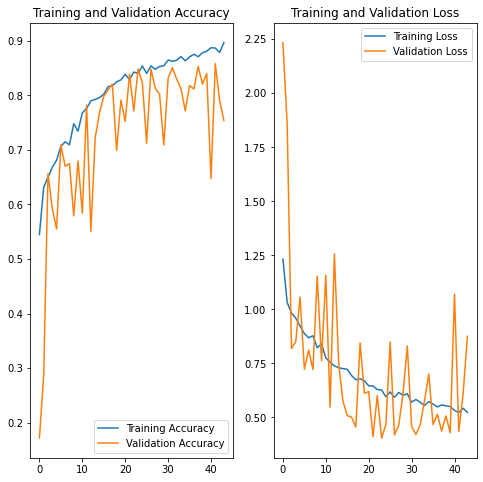

In [14]:
model_mixup = adv_model(img_width,img_height,img_channel)
epoch=80
model_train_validate_adv(model_mixup,train_generator_mixup,val_data_generator,step_size_train,step_size_valid,epoch)

## Mixup Model Test

In [16]:
mixup_best_model = load_model(filepath='C:\\Users\\R00195427\\Desktop\\Assignment\\saved_model\\adv_best_model.h5')
loss_mixup,acc_mixup=mixup_best_model.evaluate(test_data_generator,steps=test_data_generator.n//test_data_generator.batch_size)
print ('The best model Loss : ',loss_mixup)
print ('The best model Accuracy : ',acc_mixup)

150/150 [==============================] - 21s 137ms/step - loss: 0.4027 - accuracy: 0.8508
The best model Loss :  0.40272971987724304
The best model Accuracy :  0.8508333563804626


## Sample Implementation of Cutmix & Cutout

In [52]:
def cutmix_images(imgPath1,imgPath2,label1, label2, crop_size=200):
       
    img1 = Image.open(imgPath1)
    img1 = np.array(img1)
    img1_height, img1_width = img1.shape[:-1]
    
    img2 = Image.open(imgPath2)
    img2 = np.array(img2)
    img2_height, img2_width = img2.shape[:-1]
    
    
    x1 = random.randint(0,img1_height-crop_size)
    y1 = random.randint(0,img1_width-crop_size)
    

    x2 = random.randint(0,img2_height-crop_size)
    y2 = random.randint(0,img2_width-crop_size)
    

    cropped1 = img1.copy()[x1:x1+crop_size , y1:y1+crop_size,:]
    
    cropped2 = img2.copy()[x2:x2+crop_size , y2:y2+crop_size,:]
    img1[x1:x1+crop_size , y1:y1+crop_size,:] = cropped2
    img2[x2:x2+crop_size , y2:y2+crop_size,:] = cropped1
    
    alpha1 = (crop_size * crop_size) / (img1_height * img1_width)
    beta1 = 1 - alpha1
    
    alpha2 = (crop_size * crop_size) / (img2_height * img2_width)
    beta2 = 1 - alpha2
    
    newlabel1 = beta1 * label1 + alpha1 * label2
    
    newlabel2 = alpha2 * label1 + beta2 * label2
    
    return  img1, img2, newlabel1, newlabel2

def cutout(imagePath, num_holes, hole_size, rescale_to = 512):
    
    img = Image.open(imgPath)
    img = np.array(img)
    img_height, img_width = img.shape[:-1]
    
    for i in range(num_holes):    
        x = random.randint(0,img_height-hole_size)
        y = random.randint(0,img_width-hole_size)
        img[x:x+hole_size , y:y+hole_size,:] = 0
        
    #random crop a patch of rescale_to x rescale_to    
    x = random.randint(0,img_height-rescale_to)
    y = random.randint(0,img_width-rescale_to)
    return  img[x:x+rescale_to , y:y+rescale_to,:]
    

## Cutmix

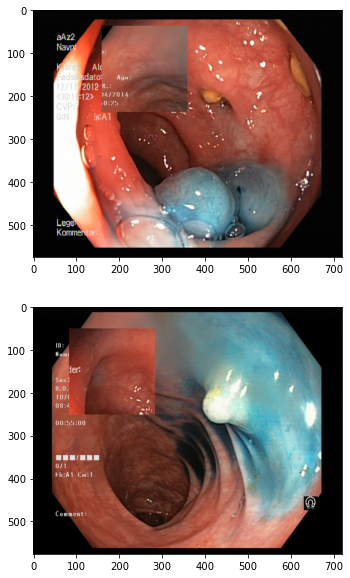

In [51]:
imgpath1 = "C:\\Users\\bless\\Desktop\\MTU-Sem2\\Deep Learning\\A02\\kvasir-dataset-v2\\train\\dyed-lifted-polyps\\0a7ece5b-caaa-496e-9e6e-0c7eab171527.jpg"
imgpath2 = "C:\\Users\\bless\\Desktop\\MTU-Sem2\\Deep Learning\\A02\\kvasir-dataset-v2\\train\\dyed-lifted-polyps\\0d903cfb-02d8-49fa-abd2-01ca60025b16.jpg"
from PIL import Image
#these labels are just some example, they doesn't reflect these images
l1 = np.array([0, 0, 0, 0, 1])
l2 = np.array([0, 0, 0, 1, 0])

img1, img2, l1, l2 = cutmix_images(imgpath1, imgpath2,l1, l2)

plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.imshow(img1)

plt.subplot(2, 1, 2)
plt.imshow(img2)


## Cutout

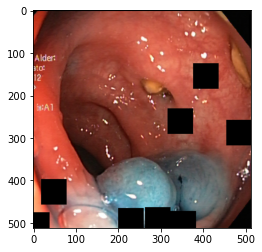

In [59]:
imgPath = "C:\\Users\\bless\\Desktop\\MTU-Sem2\\Deep Learning\\A02\\kvasir-dataset-v2\\train\\dyed-lifted-polyps\\0a7ece5b-caaa-496e-9e6e-0c7eab171527.jpg"
cutoutImg = cutout(imgPath, 10, 60)
plt.imshow(cutoutImg)

## Data Preparation for Kvasir Dataset features

In [19]:
path = 'C:\\Users\\R00195427\\Desktop\\Assignment\\kvasir-dataset-v2-features'
data_classes = os.listdir(path)
# create 6 empty dataframes for the features 
feature_JCD_df = pd.DataFrame()
feature_Tamura_df = pd.DataFrame()
feature_ColorLayout_df = pd.DataFrame()
feature_EdgeHistogram_df = pd.DataFrame()
feature_AutoColorCorrelogram_df = pd.DataFrame()
feature_PHOG_df = pd.DataFrame()
    
for data_class in data_classes:
    # loop over the 8 directories.
    sub_path = path +'\\'+data_class + '\\'
    # loop over each file in a class
    for file_path in glob.iglob(sub_path + '*.features'):
       
        #opening the file
        file_object = open(file_path)
        # reading each line, splitting feature name and values. Appending feature value in each line to a dataframe and class name as index
        feature_JCD_df = feature_JCD_df.append(pd.Series(file_object.readline().split(':')[1].rstrip('\n').split(','),name=data_class))
        feature_Tamura_df = feature_Tamura_df.append(pd.Series(file_object.readline().split(':')[1].rstrip('\n').split(','), name = data_class))
        feature_ColorLayout_df = feature_ColorLayout_df.append(pd.Series(file_object.readline().split(':')[1].rstrip('\n').split(','), name = data_class))
        feature_EdgeHistogram_df = feature_EdgeHistogram_df.append(pd.Series(file_object.readline().split(':')[1].rstrip('\n').split(','), name = data_class))
        feature_AutoColorCorrelogram_df = feature_AutoColorCorrelogram_df.append(pd.Series(file_object.readline().split(':')[1].rstrip('\n').split(','), name = data_class))
        feature_PHOG_df = feature_PHOG_df.append(pd.Series(file_object.readline().split(':')[1].rstrip('\n').split(','), name = data_class))
        
        file_object.close()

In [26]:
# concatenating all dataframes column wise fo from final dataframe
final_df = pd.concat([feature_JCD_df, feature_Tamura_df, feature_ColorLayout_df, feature_EdgeHistogram_df,\
                      feature_AutoColorCorrelogram_df, feature_PHOG_df], axis=1)
print(final_df.shape)
# making index class names into a separate column
final_df.reset_index(inplace=True)
final_df=final_df.rename(columns={"index":"class"})
final_df.head()

(8000, 1185)


,class,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
0,dyed-lifted-polyps,0.5,2.0,4.5,0.0,0.0,0.0,3.5,3.5,5.0,...,7.0,3.0,3.0,6.0,6.0,4.0,2.0,2.0,1.0,3.0
1,dyed-lifted-polyps,0.0,1.5,4.5,0.0,0.0,0.0,2.5,1.5,3.5,...,0.0,6.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0
2,dyed-lifted-polyps,1.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,14.0,3.0,5.0,14.0,0.0,0.0,4.0,3.0,0.0
3,dyed-lifted-polyps,1.5,2.5,5.5,0.5,0.5,0.5,2.5,3.0,3.5,...,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,6.0
4,dyed-lifted-polyps,3.0,3.5,6.0,0.0,0.0,0.0,1.0,0.0,0.5,...,8.0,4.0,1.0,3.0,3.0,1.0,2.0,14.0,2.0,0.0


In [9]:
# saving dataframe as csv to load later
final_df.to_csv('C:\\Users\\R00195427\\Desktop\\Assignment\\final_df.csv')
final_df=pd.read_csv('C:\\Users\\bless\\Desktop\\MTU-Sem2\\Deep Learning\A02\\final_df.csv')
final_df.drop(columns=final_df.columns[0], axis=1, inplace=True)
final_df.head()

,class,0,1,2,3,4,5,6,7,8,...,620,621,622,623,624,625,626,627,628,629
0,dyed-lifted-polyps,0.5,2.0,4.5,0.0,0.0,0.0,3.5,3.5,5.0,...,7.0,3.0,3.0,6.0,6.0,4.0,2.0,2.0,1.0,3.0
1,dyed-lifted-polyps,0.0,1.5,4.5,0.0,0.0,0.0,2.5,1.5,3.5,...,0.0,6.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0
2,dyed-lifted-polyps,1.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,14.0,3.0,5.0,14.0,0.0,0.0,4.0,3.0,0.0
3,dyed-lifted-polyps,1.5,2.5,5.5,0.5,0.5,0.5,2.5,3.0,3.5,...,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,6.0
4,dyed-lifted-polyps,3.0,3.5,6.0,0.0,0.0,0.0,1.0,0.0,0.5,...,8.0,4.0,1.0,3.0,3.0,1.0,2.0,14.0,2.0,0.0


## 6GF RandomForest Implementation

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
x=final_df.iloc[:,1:] # all columns except first column as x variable variable
y=final_df.iloc[:,0] # first column class names as y variable
x=x.astype('float64')
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=427,stratify=y)
RF_model=RandomForestClassifier()

In [11]:
def predict(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred= model.predict(x_test)
    print("Accuracy of Random Forest Model = {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))

In [12]:
predict(RF_model,x_train,y_train,x_test,y_test)

Accuracy of Random Forest Model = 76.12%


In [34]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, random_state=42)

## Hyper Prameter Optimization

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
def model_tuning_random(x_train,y_train):
    # Number of trees in random forest
    n_estimators = [int(x) for x in range(200,2000,200)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    print(random_grid)

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, random_state=42)
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(x_train, y_train)

    print(rf_random.best_params_)
    best_random = rf_random.best_estimator_
    
    return best_random

In [14]:
rf_random_model = model_tuning_random(x_train,y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}


## Model Evaluation

In [21]:
from sklearn import metrics
from sklearn.metrics import classification_report,multilabel_confusion_matrix,confusion_matrix
def predict_tuned_rf(model,x_test,y_test):
    classes = ['dyed-lifted-polyps',
            'dyed-resection-margins',
            'esophagitis','normal-cecum',
            'normal-pylorus','normal-z-line',
            'polyps',
            'ulcerative-colitis']
    y_pred= model.predict(x_test)
    print("Accuracy of Random Forest Model = {:0.2f}%".format(accuracy_score(y_pred,y_test)*100))
    print(classification_report(y_test,y_pred, target_names=classes))
    print(confusion_matrix(y_test,y_pred))

In [22]:
predict_tuned_rf(rf_random_model, x_test, y_test)

Accuracy of Random Forest Model = 77.50%
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.68      0.72      0.70       200
dyed-resection-margins       0.72      0.69      0.70       200
           esophagitis       0.77      0.68      0.72       200
          normal-cecum       0.84      0.92      0.88       200
        normal-pylorus       0.91      0.98      0.94       200
         normal-z-line       0.71      0.80      0.75       200
                polyps       0.78      0.68      0.72       200
    ulcerative-colitis       0.78      0.74      0.76       200

              accuracy                           0.78      1600
             macro avg       0.77      0.78      0.77      1600
          weighted avg       0.77      0.78      0.77      1600

[[145  52   0   0   0   0   1   2]
 [ 62 137   0   0   0   0   1   0]
 [  0   0 135   0   3  62   0   0]
 [  1   0   0 184   0   0   9   6]
 [  0   0   1   0 196   3   0   0]
 [  0   0  38